# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)

cv2.destroyAllWindows()


## Define undistortion function

In [3]:
def undistort(img):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return cv2.undistort(img, mtx, dist, None, mtx)


## Test undistortion on a chessboard image

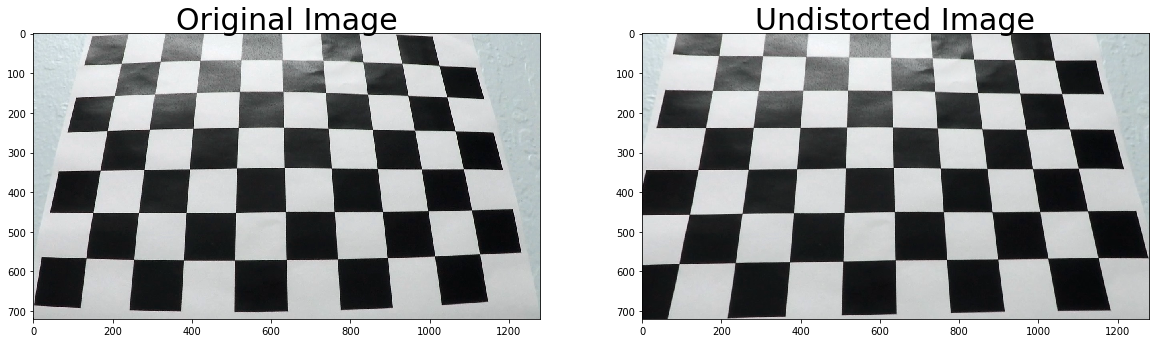

In [4]:
chess_img = cv2.imread('camera_cal/calibration3.jpg')
chess_dst = undistort(chess_img)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(chess_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(chess_dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Test undistortion on a road image

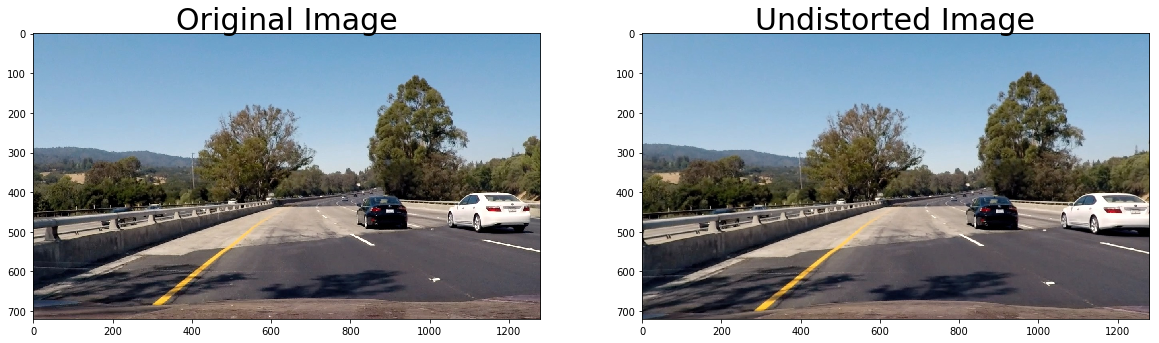

In [5]:
road_img = cv2.imread('test_images/test4.jpg')
road_dst = undistort(road_img)
road_dst = cv2.cvtColor(road_dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
ax1.imshow(road_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(road_dst)
ax2.set_title('Undistorted Image', fontsize=30)


## Use color transforms, gradients, etc., to create a thresholded binary image

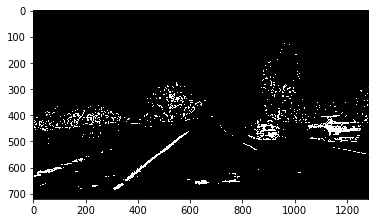

In [6]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def gradient(img, sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    return sxbinary
def combined_thersholds(img):
    # Stack each channel
    s_binary = hls_select(img, thresh=(140, 255))
    sxbinary = gradient(img)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return s_binary
    
road_img = cv2.imread('test_images/test4.jpg')
threshold_img = combined_thersholds(road_img)
plt.imshow(threshold_img, cmap='gray')


## Apply a perspective transform to rectify binary image ("birds-eye view")

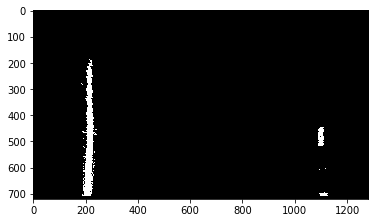

In [7]:
def birds_eye(img):
    img_size = img.shape[1::-1]
    width = img_size[0]
    height = img_size[1]
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32(
        [[200, height],  #bottom left
         [width - 200, height], #bottom right
         [685, 450], #top right - 2nd dot
         [594, 450]]) #top left - 2nd dot
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32(
        [[200, height],  #bottom left
         [width - 200, height], #bottom right
         [width - 200, 0], #top right - 2nd dot
         [200, 0]]) #top left - 2nd dot
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # euse cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M


road_img = cv2.imread('test_images/straight_lines1.jpg')
threshold_img = combined_thersholds(road_img)
warped = birds_eye(threshold_img)[0]
plt.imshow(warped, cmap='gray')
    

## Create a histogram

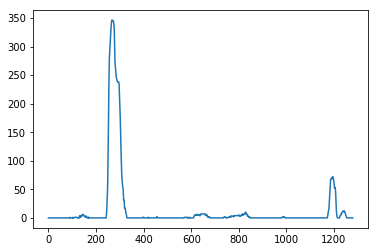

In [8]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# Create histogram of image binary activations
img = cv2.imread('test_images/test4.jpg')
img = combined_thersholds(img)
img = birds_eye(img)[0]
histogram = hist(img)
# Visualize the resulting histogram
plt.plot(histogram)


## Define a class to receive the characteristics of each line detection

In [9]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        # self.detected = False  
        # x values of the last n fits of the line
        # self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        # self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        # self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        # self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        # self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        # self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## Implement Sliding Windows, Fit a Polynomial and other relevant functions

In [19]:
def sliding_windows_search(binary_warped, left_line: Line, right_line: Line):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]

    return left_line, right_line

def search_around_poly(binary_warped, left_line, right_line):
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit
    #     
    # if not any(left_fit) or not any(right_fit):
    #     raise Exception('Line fits were empty')

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy +
                                   left_fit[2] - margin)) & (nonzerox < (left_fit[0] * (nonzeroy ** 2) +
                                                                         left_fit[1] * nonzeroy + left_fit[
                                                                             2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * (nonzeroy ** 2) +
                                                                           right_fit[1] * nonzeroy + right_fit[
                                                                               2] + margin)))
    if not any(left_lane_inds) or not any(right_lane_inds):
        raise  exec("Could not find lanes around")
    # Again, extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds]
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]

    return left_line, right_line

def fit_polynomial(img_shape, left_line: Line, right_line: Line):
    # Fit a second order polynomial to each using `np.polyfit`
    left_line.current_fit = np.polyfit(left_line.ally, left_line.allx, 2)
    right_line.current_fit = np.polyfit(right_line.ally, right_line.allx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    try:
        left_fitx = left_line.current_fit[0]*ploty**2 + left_line.current_fit[1]*ploty + left_line.current_fit[2]
        right_fitx = right_line.current_fit[0]*ploty**2 + right_line.current_fit[1]*ploty + right_line.current_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    return ploty, left_fitx, right_fitx

def measure_curvature(line: Line, y_val):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''

    # y_val is where we want radius of curvature to be measured
    # A nice place to measure is the maximum y-value, corresponding to the bottom of the image
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    
    # Calculation of R_curve (radius of curvature)
    curverad = ((1 + (2*line.current_fit[0]*y_val*ym_per_pix + line.current_fit[1])**2)**1.5) / np.absolute(2*line.current_fit[0])
    
    return curverad

def center_offset(left_line: Line, right_line: Line, y_val, frame_width):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Find the x values of the lanes at the maximum y
    left_fitx = left_line.current_fit[0]*y_val**2 + left_line.current_fit[1]*y_val + left_line.current_fit[2]
    right_fitx = right_line.current_fit[0]*y_val**2 + right_line.current_fit[1]*y_val + right_line.current_fit[2]
    
    # Calculate the offset
    pixel_offset = (frame_width / 2) - ((right_fitx - left_fitx)/2 + left_fitx)
    meter_offset = xm_per_pix * pixel_offset
    return meter_offset

def fill_lanes(undist_img, ploty=None, left_fitx=None, right_fitx=None, Minv=None):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(undist_img[:,:,0]).astype(np.uint8)   # Drop color dimensions
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, new_warp, 0.3, 0)
    return result


# Process a single frame

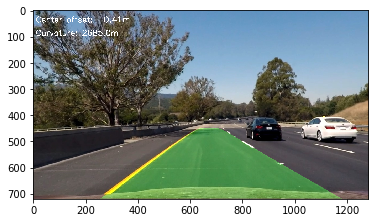

In [20]:
def process_image(img, left_line, right_line):    
    img_copy = np.copy(img)
    undist = undistort(img_copy)
    img_copy = combined_thersholds(undist)
    binary_warped, M = birds_eye(img_copy)
    Minv = np.linalg.inv(M)
    # Find our lane pixels first
    try:
        search_around_poly(binary_warped, left_line, right_line)
    except:
        sliding_windows_search(binary_warped, left_line, right_line)
    ploty, left_fitx, right_fitx = fit_polynomial(binary_warped.shape, left_line, right_line)
    left_curverad = measure_curvature(left_line_global, img.shape[0])
    right_curverad = measure_curvature(right_line_global, img.shape[0])

    offset = center_offset(left_line_global, right_line_global, img.shape[0], img.shape[1])
    dst = fill_lanes(undist,ploty, left_fitx, right_fitx,Minv)
    
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    rad_text = 'Curvature: {}m'.format(avg_rad)
    center_text = 'Center offset: {}m'.format(round(offset,2))
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(dst, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(dst, rad_text, (10,100), font, 1,(255,255,255),2)
    
    return dst
    
road_img = cv2.imread('test_images/test6.jpg')
# road_img = cv2.imread('test_images/straight_lines2.jpg')
left_line_global = Line()
right_line_global = Line()
dst = process_image(road_img, left_line_global, right_line_global)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(dst)


# Process a video

In [13]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output_videos/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
left_line_global = Line()
right_line_global = Line()
white_clip = clip1.fl_image(lambda image: process_image(image, left_line_global, right_line_global)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)


t:  49%|████▉     | 615/1260 [08:09<08:35,  1.25it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



TypeError: expected non-empty vector for x